# Skin Lesion Classification — Transfer Learning template
**Dataset:** merged HAM10000 + MSLDv2.0 (14 classes).

This notebook trains a single transfer-learning model on the dataset using PyTorch. 
**Assumptions:** dataset arranged like:
```
data/
  train/
    class_1/
      img1.jpg
      img2.jpg
    class_2/
  val/
    class_1/
    ...
```
If your dataset is packaged differently, adapt `train_dir` / `val_dir` variables below.

This notebook was autogenerated to match SE4050 assignment requirements (4 different model notebooks will be provided).
\n\n**Model:** MobileNetV3-Large

In [2]:
# Environment & imports
# Install PyTorch with CUDA support (run this cell first if CUDA is not available)
# Your system has CUDA 12.7, so use cu124 (compatible with CUDA 12.x):
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
# Alternative for CUDA 12.1:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Install other packages
%pip install torch torchvision matplotlib scikit-learn tqdm timm
import os
import time
import copy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

# Force GPU usage
if not torch.cuda.is_available():
    print("CUDA not available. Installing CPU version of PyTorch...")
    # Install CPU version if GPU not available
    !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
    import torch
    device = torch.device("cpu")
    print("Using CPU. To use GPU, install CUDA and PyTorch with CUDA support.")
else:
    device = torch.device("cuda")
    print("Device:", device)
    print("CUDA version:", torch.version.cuda if torch.cuda.is_available() else "N/A")

Looking in indexes: https://download.pytorch.org/whl/cu124
Note: you may need to restart the kernel to use updated packages.
Device: cuda
CUDA version: 12.4


In [3]:
# Paths (change these to your dataset locations)
# Download and extract your dataset folders locally, then set the paths below:
train_dir = r"D:\archive\train"
val_dir   = r"D:\archive\val"   # Example local path

# Data transforms and augmentation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_transforms)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

class_names = train_dataset.classes
num_classes = len(class_names)
print("Classes ({}):".format(num_classes), class_names)
print("Train size:", len(train_dataset), " Val size:", len(val_dataset))


Classes (10): ['Actinic keratoses', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Train size: 10648  Val size: 1327


In [4]:
# Compute class weights to address imbalance
from collections import Counter
counts = Counter([y for _, y in train_dataset.samples])
counts = [counts[i] for i in range(len(class_names))]
print("Class counts:", counts)
class_weights = torch.tensor([sum(counts)/c for c in counts], dtype=torch.float).to(device)
print("Class weights:", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)


Class counts: [693, 900, 792, 191, 1932, 1368, 660, 3408, 502, 202]
Class weights: tensor([15.3651, 11.8311, 13.4444, 55.7487,  5.5114,  7.7836, 16.1333,  3.1244,
        21.2112, 52.7129], device='cuda:0')


In [5]:
# MobileNetV3 Large (pretrained)
try:
    model = models.mobilenet_v3_large(pretrained=True)
    # Correctly identify the input features for the classifier
    num_ftrs = model.classifier[-1].in_features  # Access the last layer of the classifier
    model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
except Exception as e:
    # Fallback for older torchvision versions or different model structures
    model = models.mobilenet_v3_large(pretrained=True)
    # Attempt to access the in_features from the first layer if the above fails
    try:
        num_ftrs = model.classifier[0].in_features
        model.classifier[0] = nn.Linear(num_ftrs, num_classes)
    except Exception as e_fallback:
        print(f"Could not adapt classifier automatically: {e_fallback}")
        print("Please check the model's classifier structure and adapt the code manually.")

model = model.to(device)

c:\Users\nethm\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nethm\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# Optimizer, scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# Optional scheduler
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
scheduler = None
num_epochs = 30  # change as needed


In [7]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=30, model_name="model"):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0

    history = {"train_loss":[],"val_loss":[],"train_acc":[],"val_acc":[], "val_f1":[]}

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        # Each epoch has a training and validation phase
        for phase in ["train","val"]:
            if phase == "train":
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            y_true = []
            y_pred = []

            for inputs, labels in tqdm(loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                y_true.extend(labels.cpu().numpy().tolist())
                y_pred.extend(preds.cpu().numpy().tolist())

            epoch_loss = running_loss / (len(loader.dataset))
            epoch_acc = running_corrects / (len(loader.dataset))
            epoch_f1 = f1_score(y_true, y_pred, average='macro')
            print("{} Loss: {:.4f} Acc: {:.4f} F1: {:.4f}".format(phase, epoch_loss, epoch_acc, epoch_f1))

            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc)
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc)
                history["val_f1"].append(epoch_f1)
                # deep copy the model
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), f"{model_name}_best.pth")
        if scheduler is not None:
            scheduler.step()
        print("-"*30)

    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best val F1: {:.4f}".format(best_f1))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [8]:
# Train
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs, model_name="MobileNetV3-Large")


Epoch 1/30


100%|██████████| 333/333 [00:57<00:00,  5.75it/s]


train Loss: 1.1164 Acc: 0.5727 F1: 0.5431


100%|██████████| 42/42 [00:07<00:00,  5.34it/s]


val Loss: 0.6789 Acc: 0.7347 F1: 0.7145
------------------------------
Epoch 2/30


100%|██████████| 333/333 [00:54<00:00,  6.06it/s]


train Loss: 0.6471 Acc: 0.7240 F1: 0.7152


100%|██████████| 42/42 [00:06<00:00,  6.06it/s]


val Loss: 0.4927 Acc: 0.8116 F1: 0.7664
------------------------------
Epoch 3/30


100%|██████████| 333/333 [00:53<00:00,  6.21it/s]


train Loss: 0.5180 Acc: 0.7800 F1: 0.7693


100%|██████████| 42/42 [00:06<00:00,  6.18it/s]


val Loss: 0.3081 Acc: 0.8930 F1: 0.8777
------------------------------
Epoch 4/30


100%|██████████| 333/333 [00:52<00:00,  6.37it/s]


train Loss: 0.4407 Acc: 0.8192 F1: 0.8068


100%|██████████| 42/42 [00:06<00:00,  6.01it/s]


val Loss: 0.2687 Acc: 0.8885 F1: 0.8695
------------------------------
Epoch 5/30


100%|██████████| 333/333 [00:52<00:00,  6.35it/s]


train Loss: 0.3834 Acc: 0.8382 F1: 0.8211


100%|██████████| 42/42 [00:06<00:00,  6.09it/s]


val Loss: 0.2417 Acc: 0.9111 F1: 0.8859
------------------------------
Epoch 6/30


100%|██████████| 333/333 [00:52<00:00,  6.32it/s]


train Loss: 0.3742 Acc: 0.8557 F1: 0.8365


100%|██████████| 42/42 [00:07<00:00,  5.98it/s]


val Loss: 0.2073 Acc: 0.9246 F1: 0.9117
------------------------------
Epoch 7/30


100%|██████████| 333/333 [00:52<00:00,  6.36it/s]


train Loss: 0.3150 Acc: 0.8709 F1: 0.8596


100%|██████████| 42/42 [00:07<00:00,  5.96it/s]


val Loss: 0.2012 Acc: 0.9156 F1: 0.9064
------------------------------
Epoch 8/30


100%|██████████| 333/333 [00:52<00:00,  6.31it/s]


train Loss: 0.3079 Acc: 0.8760 F1: 0.8616


100%|██████████| 42/42 [00:06<00:00,  6.14it/s]


val Loss: 0.2195 Acc: 0.9239 F1: 0.8924
------------------------------
Epoch 9/30


100%|██████████| 333/333 [00:52<00:00,  6.34it/s]


train Loss: 0.2770 Acc: 0.8870 F1: 0.8727


100%|██████████| 42/42 [00:06<00:00,  6.03it/s]


val Loss: 0.1641 Acc: 0.9435 F1: 0.9293
------------------------------
Epoch 10/30


100%|██████████| 333/333 [00:53<00:00,  6.25it/s]


train Loss: 0.2742 Acc: 0.8901 F1: 0.8757


100%|██████████| 42/42 [00:06<00:00,  6.04it/s]


val Loss: 0.1810 Acc: 0.9420 F1: 0.9060
------------------------------
Epoch 11/30


100%|██████████| 333/333 [00:54<00:00,  6.06it/s]


train Loss: 0.2455 Acc: 0.9007 F1: 0.8887


100%|██████████| 42/42 [00:07<00:00,  5.55it/s]


val Loss: 0.1615 Acc: 0.9390 F1: 0.9239
------------------------------
Epoch 12/30


100%|██████████| 333/333 [00:55<00:00,  5.97it/s]


train Loss: 0.2511 Acc: 0.9072 F1: 0.8902


100%|██████████| 42/42 [00:07<00:00,  5.74it/s]


val Loss: 0.1601 Acc: 0.9510 F1: 0.9349
------------------------------
Epoch 13/30


100%|██████████| 333/333 [00:54<00:00,  6.15it/s]


train Loss: 0.2273 Acc: 0.9103 F1: 0.9033


100%|██████████| 42/42 [00:07<00:00,  5.51it/s]


val Loss: 0.1561 Acc: 0.9503 F1: 0.9321
------------------------------
Epoch 14/30


100%|██████████| 333/333 [00:53<00:00,  6.18it/s]


train Loss: 0.2204 Acc: 0.9143 F1: 0.9077


100%|██████████| 42/42 [00:06<00:00,  6.01it/s]


val Loss: 0.1492 Acc: 0.9510 F1: 0.9324
------------------------------
Epoch 15/30


100%|██████████| 333/333 [00:52<00:00,  6.32it/s]


train Loss: 0.2024 Acc: 0.9191 F1: 0.9096


100%|██████████| 42/42 [00:07<00:00,  5.99it/s]


val Loss: 0.1361 Acc: 0.9540 F1: 0.9392
------------------------------
Epoch 16/30


100%|██████████| 333/333 [00:52<00:00,  6.31it/s]


train Loss: 0.1909 Acc: 0.9267 F1: 0.9196


100%|██████████| 42/42 [00:06<00:00,  6.01it/s]


val Loss: 0.1545 Acc: 0.9510 F1: 0.9332
------------------------------
Epoch 17/30


100%|██████████| 333/333 [00:52<00:00,  6.34it/s]


train Loss: 0.1902 Acc: 0.9281 F1: 0.9205


100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


val Loss: 0.1476 Acc: 0.9488 F1: 0.9338
------------------------------
Epoch 18/30


100%|██████████| 333/333 [00:52<00:00,  6.34it/s]


train Loss: 0.1884 Acc: 0.9258 F1: 0.9174


100%|██████████| 42/42 [00:07<00:00,  5.77it/s]


val Loss: 0.1306 Acc: 0.9510 F1: 0.9370
------------------------------
Epoch 19/30


100%|██████████| 333/333 [00:52<00:00,  6.34it/s]


train Loss: 0.1883 Acc: 0.9287 F1: 0.9209


100%|██████████| 42/42 [00:06<00:00,  6.01it/s]


val Loss: 0.1296 Acc: 0.9563 F1: 0.9364
------------------------------
Epoch 20/30


100%|██████████| 333/333 [00:52<00:00,  6.32it/s]


train Loss: 0.1665 Acc: 0.9305 F1: 0.9250


100%|██████████| 42/42 [00:07<00:00,  5.97it/s]


val Loss: 0.1416 Acc: 0.9578 F1: 0.9399
------------------------------
Epoch 21/30


100%|██████████| 333/333 [00:52<00:00,  6.35it/s]


train Loss: 0.1641 Acc: 0.9348 F1: 0.9292


100%|██████████| 42/42 [00:07<00:00,  5.96it/s]


val Loss: 0.1522 Acc: 0.9563 F1: 0.9409
------------------------------
Epoch 22/30


100%|██████████| 333/333 [00:52<00:00,  6.32it/s]


train Loss: 0.1688 Acc: 0.9360 F1: 0.9289


100%|██████████| 42/42 [00:06<00:00,  6.01it/s]


val Loss: 0.1410 Acc: 0.9495 F1: 0.9304
------------------------------
Epoch 23/30


100%|██████████| 333/333 [00:52<00:00,  6.34it/s]


train Loss: 0.1564 Acc: 0.9378 F1: 0.9322


100%|██████████| 42/42 [00:07<00:00,  5.86it/s]


val Loss: 0.1269 Acc: 0.9593 F1: 0.9443
------------------------------
Epoch 24/30


100%|██████████| 333/333 [00:52<00:00,  6.34it/s]


train Loss: 0.1510 Acc: 0.9406 F1: 0.9359


100%|██████████| 42/42 [00:07<00:00,  5.93it/s]


val Loss: 0.1110 Acc: 0.9646 F1: 0.9568
------------------------------
Epoch 25/30


100%|██████████| 333/333 [00:52<00:00,  6.36it/s]


train Loss: 0.1562 Acc: 0.9418 F1: 0.9320


100%|██████████| 42/42 [00:07<00:00,  5.98it/s]


val Loss: 0.1441 Acc: 0.9638 F1: 0.9466
------------------------------
Epoch 26/30


100%|██████████| 333/333 [00:52<00:00,  6.30it/s]


train Loss: 0.1612 Acc: 0.9388 F1: 0.9273


100%|██████████| 42/42 [00:07<00:00,  5.75it/s]


val Loss: 0.0982 Acc: 0.9706 F1: 0.9550
------------------------------
Epoch 27/30


100%|██████████| 333/333 [00:52<00:00,  6.32it/s]


train Loss: 0.1432 Acc: 0.9431 F1: 0.9373


100%|██████████| 42/42 [00:07<00:00,  5.95it/s]


val Loss: 0.1166 Acc: 0.9653 F1: 0.9468
------------------------------
Epoch 28/30


100%|██████████| 333/333 [00:52<00:00,  6.37it/s]


train Loss: 0.1245 Acc: 0.9461 F1: 0.9431


100%|██████████| 42/42 [00:07<00:00,  5.93it/s]


val Loss: 0.0974 Acc: 0.9676 F1: 0.9513
------------------------------
Epoch 29/30


100%|██████████| 333/333 [00:53<00:00,  6.24it/s]


train Loss: 0.1380 Acc: 0.9437 F1: 0.9397


100%|██████████| 42/42 [00:06<00:00,  6.06it/s]


val Loss: 0.1460 Acc: 0.9623 F1: 0.9491
------------------------------
Epoch 30/30


100%|██████████| 333/333 [00:53<00:00,  6.26it/s]


train Loss: 0.1334 Acc: 0.9439 F1: 0.9407


100%|██████████| 42/42 [00:06<00:00,  6.16it/s]

val Loss: 0.0957 Acc: 0.9706 F1: 0.9584
------------------------------
Training complete in 30m 10s
Best val F1: 0.9584


In [9]:
def plot_history(history, model_name="model"):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title(f"{model_name} Loss")

    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.plot(epochs, history["val_acc"], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title(f"{model_name} Accuracy")
    plt.show()


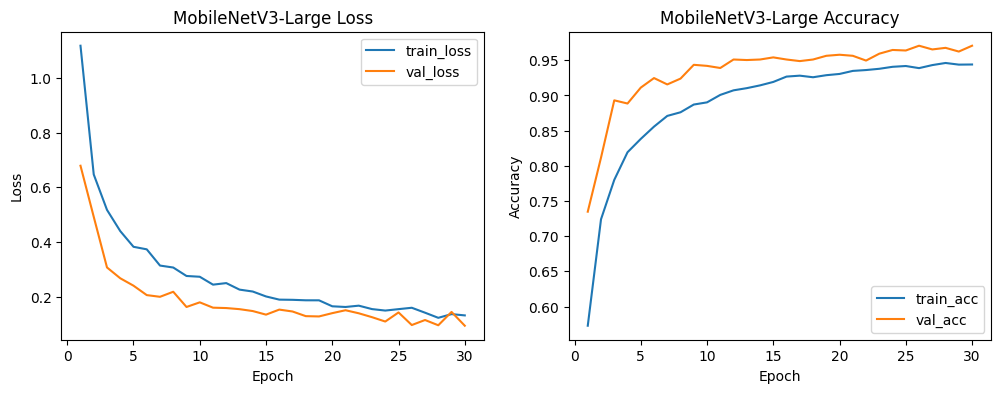

In [10]:
plot_history(history, model_name="MobileNetV3-Large")


In [11]:
# Load best model checkpoint (if needed) and run final evaluation on validation set
def evaluate_model(model):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())
    
    # Fix sklearn warnings by setting zero_division parameter
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)

In [12]:
evaluate_model(model)

                         precision    recall  f1-score   support

      Actinic keratoses       0.93      0.88      0.90        86
             Chickenpox       0.98      0.98      0.98       112
                 Cowpox       0.96      1.00      0.98        99
         Dermatofibroma       0.95      0.91      0.93        23
                   HFMD       0.98      0.99      0.98       241
                Healthy       0.98      0.98      0.98       171
                Measles       0.96      1.00      0.98        82
              Monkeypox       0.99      0.97      0.98       426
Squamous cell carcinoma       0.85      0.90      0.88        62
       Vascular lesions       0.96      1.00      0.98        25

               accuracy                           0.97      1327
              macro avg       0.96      0.96      0.96      1327
           weighted avg       0.97      0.97      0.97      1327

Confusion matrix:
 [[ 76   0   0   0   0   0   0   0  10   0]
 [  0 110   0   0   0   0

Note: you may need to restart the kernel to use updated packages.
Test classes order: ['Actinic keratoses', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Test size: 1337

Test set class distribution:
  Actinic keratoses: 88
  Chickenpox: 113
  Cowpox: 99
  Dermatofibroma: 25
  HFMD: 242
  Healthy: 171
  Measles: 83
  Monkeypox: 426
  Squamous cell carcinoma: 64
  Vascular lesions: 26

✅ Loaded checkpoint: MobileNetV3-Large_best.pth

TEST SET EVALUATION RESULTS
Overall Accuracy: 0.966
F1 Score (Macro): 0.946
F1 Score (Weighted): 0.966

Detailed Classification Report:
                         precision    recall  f1-score   support

      Actinic keratoses       0.92      0.80      0.85        88
             Chickenpox       0.97      0.96      0.96       113
                 Cowpox       0.93      1.00      0.97        99
         Dermatofibroma       0.91      0.84      0.88        25
               

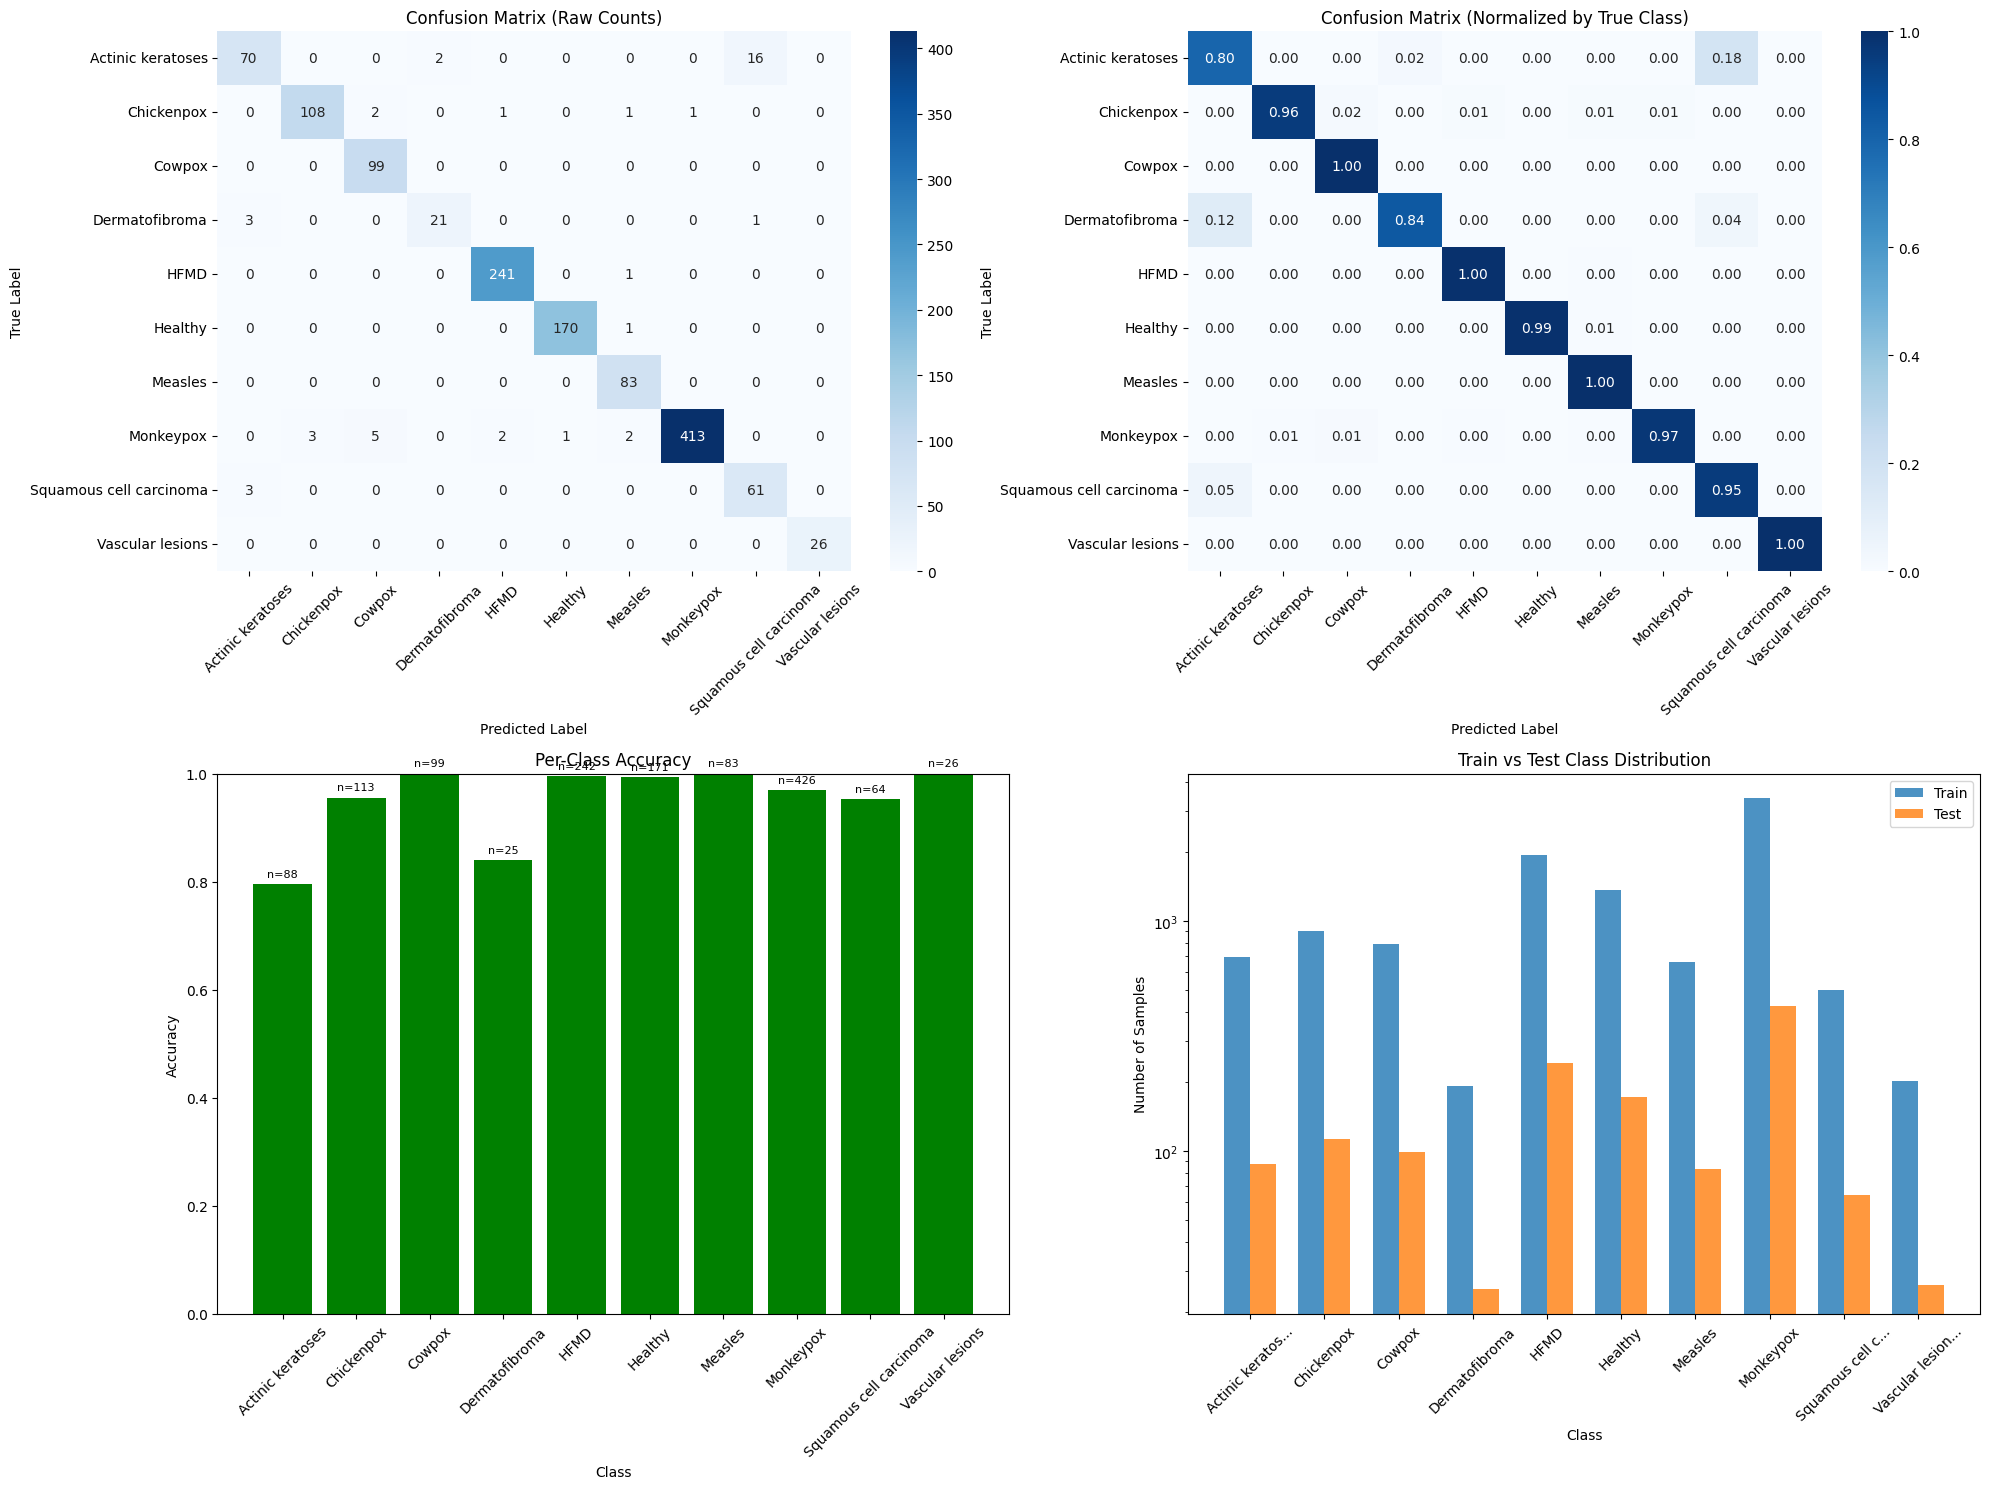


DIAGNOSTIC INFORMATION

Classes with poor performance (accuracy < 0.1):

Model's prediction bias (most frequently predicted classes):
  Monkeypox: 414 predictions (31.0%)
  HFMD: 244 predictions (18.2%)
  Healthy: 171 predictions (12.8%)
  Chickenpox: 111 predictions (8.3%)
  Cowpox: 106 predictions (7.9%)

Suggestions for improvement:
1. The model appears to be heavily biased toward certain classes (especially HFMD)
2. Consider data augmentation or resampling for underrepresented classes
3. Adjust class weights more aggressively
4. Consider using focal loss instead of weighted cross-entropy
5. Ensure test set class distribution matches expected real-world distribution

✅ Saved detailed predictions to: test_predictions_detailed.csv

Misclassification summary:
Total misclassified: 45/1337 (3.4%)
Most common misclassifications:
  Actinic keratoses → Squamous cell carcinoma: 16 cases
  Monkeypox → Cowpox: 5 cases
  Monkeypox → Chickenpox: 3 cases
  Dermatofibroma → Actinic keratoses: 3 c

In [14]:
# Test Set Evaluation with Improved Error Handling
%pip install pandas seaborn
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# path to test data 
test_dir = r"D:\archive\test"
# use same transforms as val_transforms to keep inputs consistent
test_dataset = datasets.ImageFolder(test_dir, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print("Test classes order:", test_dataset.classes)
print("Test size:", len(test_dataset))

# Check class distribution in test set
test_class_counts = {}
for _, label in test_dataset.samples:
    class_name = test_dataset.classes[label]
    test_class_counts[class_name] = test_class_counts.get(class_name, 0) + 1

print("\nTest set class distribution:")
for class_name, count in test_class_counts.items():
    print(f"  {class_name}: {count}")

# load best checkpoint (if you saved it during training)
ckpt_path = "MobileNetV3-Large_best.pth"   # adjust if different
try:
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state)
    print(f"\n✅ Loaded checkpoint: {ckpt_path}")
except Exception as e:
    print(f"⚠️ Checkpoint load failed (using current model): {e}")

model.to(device)
model.eval()

y_true = []
y_pred = []
probs = []   # optional: predicted probabilities

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        ps = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())
        probs.extend(ps.cpu().numpy().tolist())

# Calculate metrics with zero_division parameter to fix warnings
print("\n" + "="*50)
print("TEST SET EVALUATION RESULTS")
print("="*50)

# Overall accuracy
accuracy = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Overall Accuracy: {accuracy:.3f}")
print(f"F1 Score (Macro): {f1_macro:.3f}")
print(f"F1 Score (Weighted): {f1_weighted:.3f}")

print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Raw Confusion Matrix:")
print(cm)

# Enhanced confusion matrix visualization
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
# Use seaborn for better heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Raw Counts)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Normalized confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.subplot(2, 2, 2)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Normalized by True Class)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Class-wise performance analysis
plt.subplot(2, 2, 3)
class_accuracies = []
class_support = []
for i in range(len(class_names)):
    if cm[i].sum() > 0:  # Only if class has samples
        class_acc = cm[i, i] / cm[i].sum()
        class_accuracies.append(class_acc)
        class_support.append(cm[i].sum())
    else:
        class_accuracies.append(0)
        class_support.append(0)

bars = plt.bar(range(len(class_names)), class_accuracies, 
               color=['red' if acc < 0.1 else 'orange' if acc < 0.5 else 'green' 
                      for acc in class_accuracies])
plt.title("Per-Class Accuracy")
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.ylim(0, 1)

# Add support numbers on bars
for i, (bar, support) in enumerate(zip(bars, class_support)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'n={support}', ha='center', va='bottom', fontsize=8)

# Class distribution comparison
plt.subplot(2, 2, 4)
class_names_short = [name[:15] + '...' if len(name) > 15 else name for name in class_names]
# Get train counts from train_dataset if available
if 'train_dataset' in globals():
    train_class_counts = {}
    for _, label in train_dataset.samples:
        class_name = train_dataset.classes[label]
        train_class_counts[class_name] = train_class_counts.get(class_name, 0) + 1
    train_counts = [train_class_counts.get(class_names[i], 0) for i in range(len(class_names))]
else:
    train_counts = [0] * len(class_names)
test_counts = [test_class_counts.get(class_names[i], 0) for i in range(len(class_names))]

x = np.arange(len(class_names))
width = 0.35
plt.bar(x - width/2, train_counts, width, label='Train', alpha=0.8)
plt.bar(x + width/2, test_counts, width, label='Test', alpha=0.8)
plt.title("Train vs Test Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(x, class_names_short, rotation=45)
plt.legend()
plt.yscale('log')  # Log scale to better show differences

plt.tight_layout()
plt.show()

# Identify problematic classes
print("\n" + "="*50)
print("DIAGNOSTIC INFORMATION")
print("="*50)

print("\nClasses with poor performance (accuracy < 0.1):")
for i, (class_name, acc, support) in enumerate(zip(class_names, class_accuracies, class_support)):
    if acc < 0.1 and support > 0:
        print(f"  {class_name}: {acc:.3f} accuracy, {support} samples")
    elif support == 0:
        print(f"  {class_name}: No test samples available")

print("\nModel's prediction bias (most frequently predicted classes):")
pred_counts = np.bincount(y_pred, minlength=len(class_names))
for i in np.argsort(pred_counts)[::-1][:5]:  # Top 5 most predicted
    print(f"  {class_names[i]}: {pred_counts[i]} predictions ({pred_counts[i]/len(y_pred)*100:.1f}%)")

print("\nSuggestions for improvement:")
print("1. The model appears to be heavily biased toward certain classes (especially HFMD)")
print("2. Consider data augmentation or resampling for underrepresented classes")
print("3. Adjust class weights more aggressively")
print("4. Consider using focal loss instead of weighted cross-entropy")
print("5. Ensure test set class distribution matches expected real-world distribution")

# Save detailed results
filenames = [p[0] for p in test_dataset.samples]  # full relative paths
df = pd.DataFrame({
    "file": [os.path.basename(f) for f in filenames],  # Just filename, not full path
    "true_label": [class_names[i] for i in y_true],
    "pred_label": [class_names[i] for i in y_pred],
    "confidence": [round(float(np.max(p)), 4) for p in probs],
    "correct": [t == p for t, p in zip(y_true, y_pred)]
})

# Add per-class confidence statistics
df.to_csv("test_predictions_detailed.csv", index=False)
print(f"\n✅ Saved detailed predictions to: test_predictions_detailed.csv")

# Summary of misclassifications
print(f"\nMisclassification summary:")
misclassified = df[~df['correct']]
if len(misclassified) > 0:
    print(f"Total misclassified: {len(misclassified)}/{len(df)} ({len(misclassified)/len(df)*100:.1f}%)")
    print("Most common misclassifications:")
    misclass_pairs = misclassified.groupby(['true_label', 'pred_label']).size().sort_values(ascending=False)
    for (true_label, pred_label), count in misclass_pairs.head(10).items():
        print(f"  {true_label} → {pred_label}: {count} cases")
else:
    print("Perfect classification! (This is unlikely - please verify your data)")

## Notes and next steps
- Tune learning rates, batch size, augmentation.
- Consider 5-fold cross validation for robustness.
- Use mixed precision (torch.cuda.amp) to speed up training on large GPUs.
- Save final models and record results in a comparison table.